This notebook tries to reconstruct the loudest BBH signal in the MDC in the case where parameters are unknown. We maximize the likelihood over 11 parameters, with informative bounds on the chirp mass and coalescence time.

In [1]:
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src')
from get_data import convert_data_dict_to_frequency_series_dict
from likelihood_better import MDCGaussianNoise2

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
tsd1 = TimeSeries.read('../data/loudest_BBH/loudest_E1.gwf', channel='E1:STRAIN')
tsd2 = TimeSeries.read('../data/loudest_BBH/loudest_E2.gwf', channel='E2:STRAIN')
tsd3 = TimeSeries.read('../data/loudest_BBH/loudest_E3.gwf', channel='E3:STRAIN')

In [3]:
tsd = {'E1': tsd1, 'E2': tsd2, 'E3': tsd3}
fft, psd = convert_data_dict_to_frequency_series_dict(tsd)

In [13]:
# Read parameters of the loudest BBH and instanciate likelihood model

params = np.loadtxt('../data/loudest_BBH/list_mdc1_v2.txt')
index_loudest = np.argmax(params[:,-2])
tc_loudest1 = params[index_loudest,2]
tc_loudest2 = params[index_loudest,3]
t0_loudest = params[index_loudest,1]

params_signal = {
    "mass1": params[index_loudest, 4],
    "mass2": params[index_loudest, 5],
    "z": params[index_loudest, 16],
    "distance": params[index_loudest, -8],
    "spin1x": params[index_loudest, 7],
    "spin1y": params[index_loudest, 8],
    "spin1z": params[index_loudest, 9],
    "spin2x": params[index_loudest, 11],
    "spin2y": params[index_loudest, 12],
    "spin2z": params[index_loudest, 13],
    "inclination": params[index_loudest, 21],
    "ra": params[index_loudest, 18],
    "dec": params[index_loudest, 19],
    'polarization': params[index_loudest, 20],
}

# Convert masses from source frame to detector frame
params_signal['mass1'] *= (1 + params_signal['z'])
params_signal['mass2'] *= (1 + params_signal['z'])
chirp_mass = (params_signal['mass1'] * params_signal['mass2'])**(3/5) / (params_signal['mass1'] + params_signal['mass2'])**(1/5)
print('Chirp mass: ' +format(chirp_mass, '.2f'))

# Parameters over which we want to maximize
variable_params = ['mass1', 'mass2', 'spin1z', 'spin2z', 'distance', 'polarization', 'inclination', 'tc', 'coa_phase', 'ra', 'dec']

# Fixed parameters
static_params = {
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0., 
              'eccentricity': 0 }


model = MDCGaussianNoise2(fft, psd, approximant='IMRPhenomXPHM', variable_params=variable_params, static_params=static_params)
estimated_tc = 1001620460.2925069

Chirp mass: 21.06
True signal parameters unknown. Cannot compute optimal likelihood.


In [5]:
# Define bounds for parameters over which to maximize
default_angle_bound = (0, 2 * np.pi)
tc_bound = (1001620460.0, 1001620461) # Very strict for the moment
Mc_bound = (20, 22) # Assume it is known with 10% uncertainty from pystampas
q_bound = (1, 1.5)
spinz_bound = (-0.97, 0.97)
default_iota_bound = (0, np.pi)
default_dec_bound = (-np.pi / 2, np.pi /2)
distance_bound = (100, 100000)


bounds = [Mc_bound, q_bound, spinz_bound, spinz_bound, distance_bound, default_angle_bound, default_iota_bound, tc_bound, \
          default_angle_bound, default_angle_bound, default_dec_bound]
model.maximize(max_iterations=1000, tol=1e-6, bounds=bounds)

Iteration 52: negative_loglr = -170362.48896308176
Maximization complete
Maximum log-likelihood ratio: 170362.48896308176


             message: Optimization terminated successfully.
             success: True
                 fun: -170362.48896308176
                   x: [ 2.113e+01  1.485e+00 -6.810e-01 -6.851e-01
                        6.806e+04  4.927e+00  4.823e-01  1.002e+09
                        3.295e+00  1.700e+00  1.769e-01]
                 nit: 52
                nfev: 8745
          population: [[ 2.113e+01  1.485e+00 ...  1.700e+00  1.769e-01]
                       [ 2.095e+01  1.155e+00 ...  3.292e+00 -7.513e-01]
                       ...
                       [ 2.069e+01  1.081e+00 ...  2.261e+00 -8.700e-01]
                       [ 2.171e+01  1.391e+00 ...  2.196e+00  8.147e-01]]
 population_energies: [-1.704e+05 -1.704e+05 ... -1.704e+05 -1.704e+05]

In [6]:
print(model.maximized_params)

{'mass1': 24.386688899999996, 'mass2': 23.9879843, 'spin1z': 0.061211, 'spin2z': 0.112059, 'distance': 545.6354, 'polarization': 1.295625, 'inclination': 2.002555, 'tc': 1001620460.3104967, 'coa_phase': 3.2947792534695277, 'ra': -1.418225, 'dec': 0.795954, 'z': 0.1137, 'spin1x': -0.023644, 'spin1y': 0.037543, 'spin2x': -0.080838, 'spin2y': 0.007908, 'approximant': 'IMRPhenomXPHM', 'f_lower': 5}


In [7]:
print(params_signal)

{'mass1': 24.386688899999996, 'mass2': 23.9879843, 'z': 0.1137, 'distance': 545.6354, 'spin1x': -0.023644, 'spin1y': 0.037543, 'spin1z': 0.061211, 'spin2x': -0.080838, 'spin2y': 0.007908, 'spin2z': 0.112059, 'inclination': 2.002555, 'ra': -1.418225, 'dec': 0.795954, 'polarization': 1.295625, 'approximant': 'IMRPhenomXPHM', 'f_lower': 5}


In [8]:
snr_E1 = model.det_optimal_snrsq('E1')**0.5
snr_E2 = model.det_optimal_snrsq('E2')**0.5
snr_E3 = model.det_optimal_snrsq('E3')**0.5
snr_maximized = np.sqrt(snr_E1**2 + snr_E2**2 + snr_E3**2)
snr_nominal = params[index_loudest, -2]
print(snr_maximized, snr_nominal)

579.571002836093 587.553918


## Signal reconstruction

We reconstruct the signal from the set of maximized parameters and compare with the original data.

In [9]:
signal_reconstructed = model.reconstruct_signal()

Waveform approximate duration: 55.1s
Segment duration: 64.0s


### Time domain

Text(0, 0.5, 'Strain')

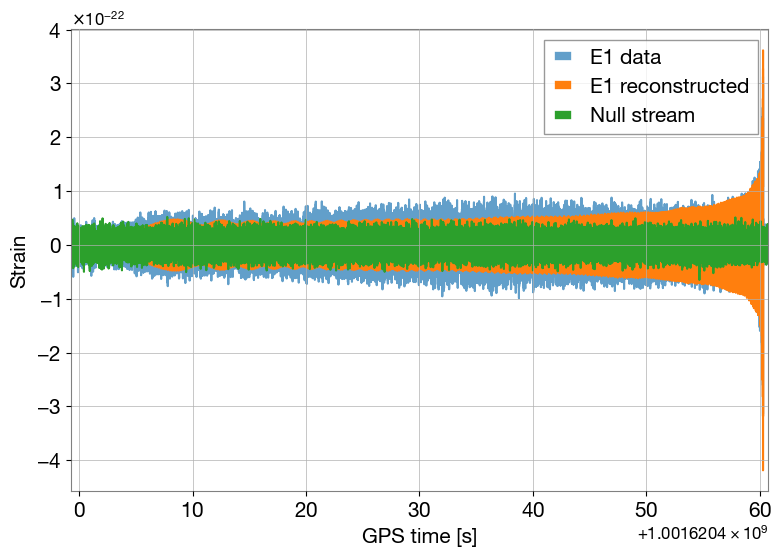

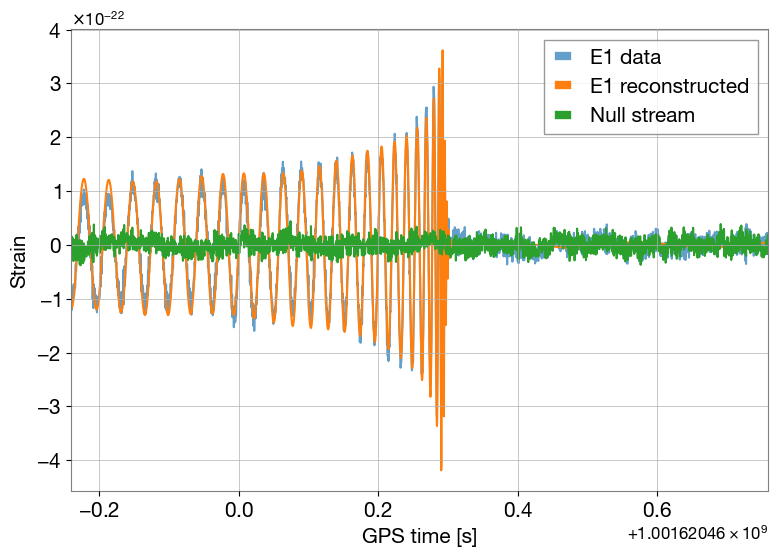

In [10]:
tsd_r = signal_reconstructed['E1'].to_timeseries() # Reconstructed time series in E1
tsd = tsd1.bandpass(4,1024) # Original E1 time series (bandpassed for visualization)
tsd_null = (tsd1 + tsd2 + tsd3) / np.sqrt(3) # Null stream time series (order of magnitude of the noise)
tsd_null = tsd_null.bandpass(4,1024)

plt.figure(figsize=(9,6))
ax = plt.gca()
plt.plot(tsd.times.value, tsd, alpha=0.7, label='E1 data')
ax.plot(tsd_r.get_sample_times(), tsd_r, label='E1 reconstructed')
ax.plot(tsd_null.times.value, tsd_null, label='Null stream')
ax.set_xlim(t0_loudest, tc_loudest1+0.5)
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('GPS time [s]', fontsize=15)
ax.set_ylabel('Strain', fontsize=15)

# Zoom on the merger
plt.figure(figsize=(9,6))
ax = plt.gca()
plt.plot(tsd.times.value, tsd, alpha=0.7, label='E1 data')
ax.plot(tsd_r.get_sample_times(), tsd_r, label='E1 reconstructed')
ax.plot(tsd_null.times.value, tsd_null, label='Null stream')
ax.set_xlim(tc_loudest1-0.5, tc_loudest1+0.5)
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('GPS time [s]', fontsize=15)
ax.set_ylabel('Strain', fontsize=15)

Text(0, 0.5, 'Strain')

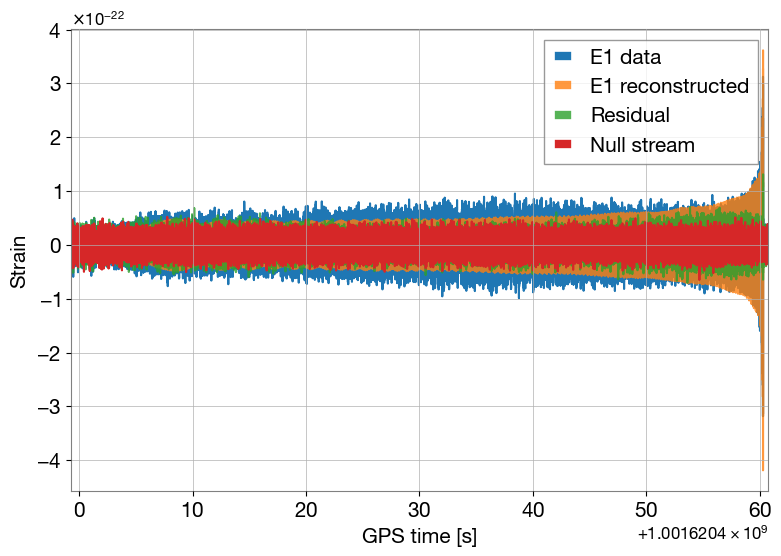

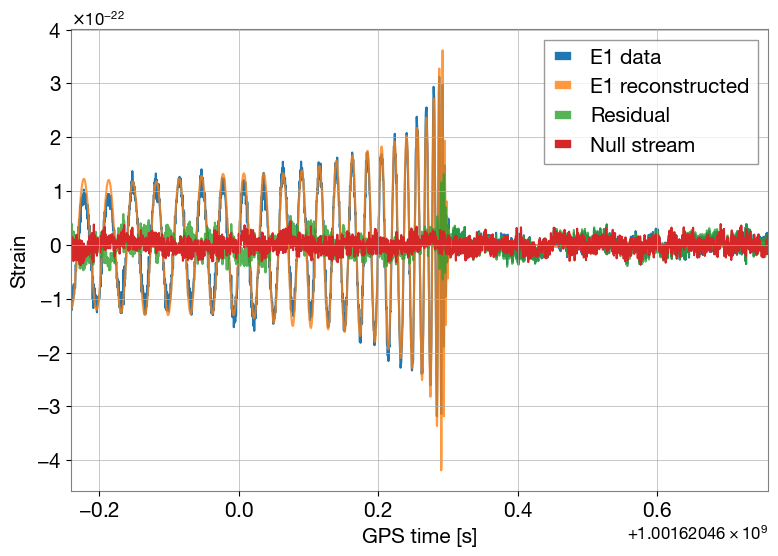

In [11]:
t1 = tsd.times.value
t2 = tsd_r.get_sample_times().data

h1 = tsd.value
h2 = tsd_r.data

from scipy.interpolate import interp1d

h_of_t = interp1d(t2, h2, bounds_error=False, fill_value=0)
h_new = h_of_t(t1)

residual = TimeSeries(h1 - h_new, times=t1)

plt.figure(figsize=(9,6))
ax = plt.gca()
ax.plot(t1, h1, label='E1 data')
ax.plot(t1, h_new, alpha=0.8, label='E1 reconstructed')
ax.plot(t1, h1 - h_new, alpha=0.8, label='Residual')
ax.plot(tsd_null.times, tsd_null, label='Null stream')
ax.set_xlim(t0_loudest, tc_loudest1+0.5)

ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('GPS time [s]', fontsize=15)
ax.set_ylabel('Strain', fontsize=15)

plt.figure(figsize=(9,6))
ax = plt.gca()
ax.plot(t1, h1, label='E1 data')
ax.plot(t1, h_new, alpha=0.8, label='E1 reconstructed')
ax.plot(t1, h1 - h_new, alpha=0.8, label='Residual')
ax.plot(tsd_null.times, tsd_null, label='Null stream')
ax.set_xlim(tc_loudest1-0.5, tc_loudest1+0.5)

ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('GPS time [s]', fontsize=15)
ax.set_ylabel('Strain', fontsize=15)

## Frequency domain

Text(0, 0.5, 'PSD [1/Hz]')

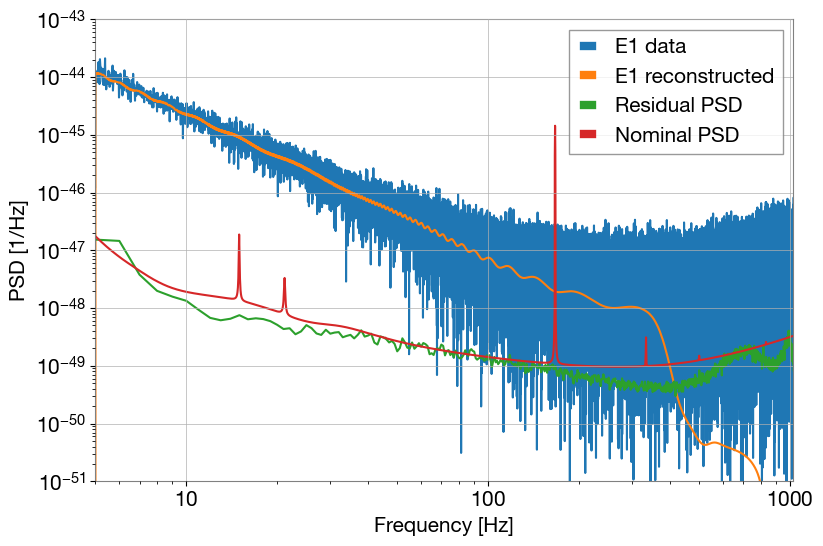

In [12]:
residual_psd = residual.psd(1.0)

plt.figure(figsize=(9,6))
ax = plt.gca()
ax.loglog(fft['E1'].get_sample_frequencies(), np.abs(fft['E1'])**2, label='E1 data')
ax.loglog(signal_reconstructed['E1'].get_sample_frequencies(), np.abs(signal_reconstructed['E1'])**2, label='E1 reconstructed')
ax.loglog(residual_psd.frequencies, residual_psd, label='Residual PSD')
ax.loglog(psd['E1'].get_sample_frequencies(), psd['E1'], label='Nominal PSD')
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlim(5, 1024)
ax.set_ylim(1e-51, 1e-43)
ax.set_xlabel('Frequency [Hz]', fontsize=15)
ax.set_ylabel('PSD [1/Hz]', fontsize=15)

## Conclusion